
# <center> Bayesian Learning Strategy to predict Stock Prices </center>

In [ ]:
import numpy as np
import pandas as pd
import random
from scipy.stats import norm, multivariate_normal
import matplotlib.pyplot as plt
import seaborn as sns
!pip install yfinance
import yfinance as yf
sns.set_theme()


The goal of this project is to implement a Bayesian strategy for 1 of 10 picked stocks with the rest acting as a reference. For this we start by downloading data from Yahoo Finance. We will develop a Bayesian Learning strategy for trading AAPL stock.

In [ ]:
Y = 'AAPL'
equities = [Y, 'AMZN', 'MSFT', 'GOOG', 'TSLA', 'META', 'AMD', 'NVDA', 'GS', 'ADBE']
start_date = "2020-01-01"
end_date = "2022-01-01"

data = yf.download(" ".join(equities), start=start_date, end=end_date)['Adj Close']
data.head()


[*********************100%***********************]  10 of 10 completed


,AAPL,ADBE,AMD,AMZN,GOOG,GS,META,MSFT,NVDA,TSLA
Date,,,,,,,,,,
2020-01-02,73.561539,334.429993,49.099998,94.900497,68.368500,220.518524,209.779999,156.591980,59.785843,28.684000
2020-01-03,72.846352,331.809998,48.599998,93.748497,68.032997,217.939926,208.669998,154.642151,58.828907,29.534000
2020-01-06,73.426826,333.709991,48.389999,95.143997,69.710503,220.170303,212.600006,155.041855,59.075619,30.102667
2020-01-07,73.081512,333.390015,48.250000,95.343002,69.667000,221.619614,213.059998,153.628265,59.790821,31.270666
2020-01-08,74.257111,337.869995,47.830002,94.598503,70.216003,223.755875,215.220001,156.075287,59.902966,32.809334


We'll be working with daily returns of these stocks as our input dataset. We also create the output dataset as the one-day forward price of AAPL stocks

In [ ]:
returnsX = (data.shift(-1)/data - 1).fillna(0)
returnsY= returnsX['AAPL'].shift(-1).fillna(0)
returnsX.head()


,AAPL,ADBE,AMD,AMZN,GOOG,GS,META,MSFT,NVDA,TSLA
Date,,,,,,,,,,
2020-01-02,-0.009722,-0.007834,-0.010183,-0.012139,-0.004907,-0.011693,-0.005291,-0.012452,-0.016006,0.029633
2020-01-03,0.007968,0.005726,-0.004321,0.014886,0.024657,0.010234,0.018834,0.002585,0.004194,0.019255
2020-01-06,-0.004703,-0.000959,-0.002893,0.002092,-0.000624,0.006583,0.002164,-0.009117,0.012107,0.038801
2020-01-07,0.016086,0.013438,-0.008705,-0.007809,0.007880,0.009639,0.010138,0.015928,0.001876,0.049205
2020-01-08,0.021241,0.007636,0.023834,0.004799,0.011044,0.020357,0.014311,0.012493,0.010983,-0.021945


The following plots show the distribution of the forward AAPL price with different current stock prices.

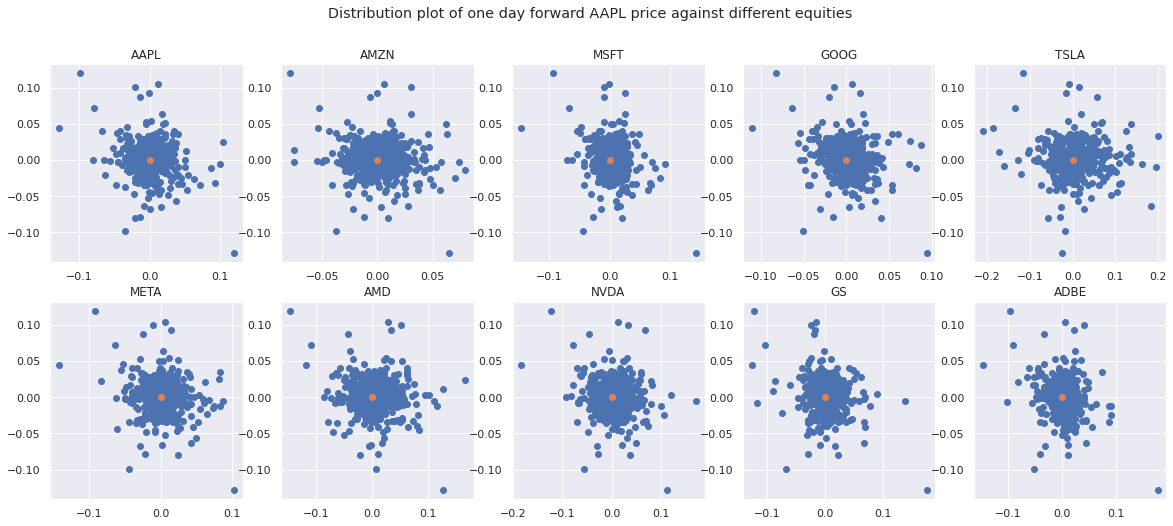

In [ ]:
fig, ax = plt.subplots(2,5,figsize=(20, 8))
fig.suptitle("Distribution plot of one day forward AAPL price against different equities")
for i in range(10):
    row, col = i//5, i%5
    ax[row,col].scatter(returnsX[equities[i]], returnsY)
    ax[row,col].scatter([0], [0])
    ax[row,col].set_title(equities[i])
_ = plt.show()


The following heatmap shows how different stock prices are correlated. The tech stocks seem to have high degree of correlation, which will be helpful in predicting AAPL (another tech stock) price movement

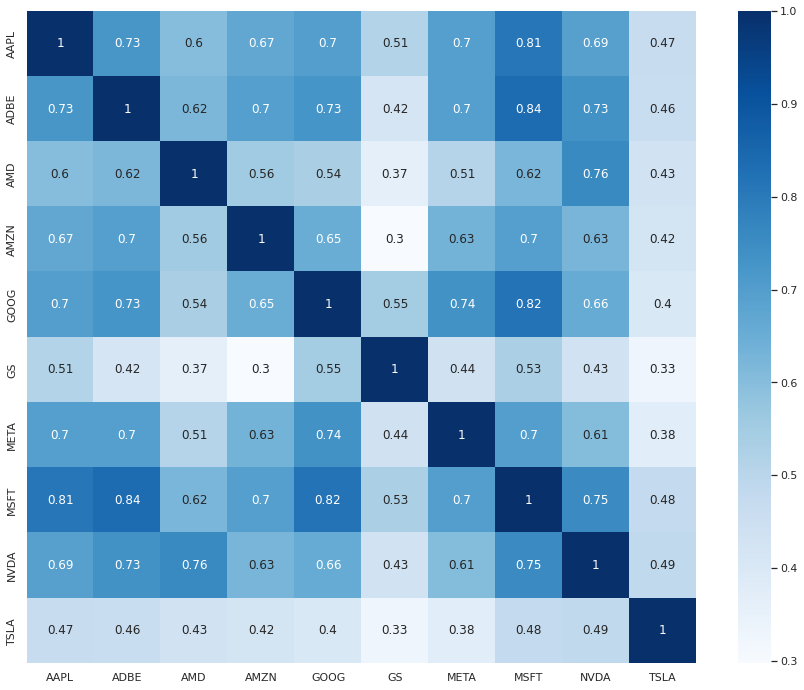

In [ ]:
plt.figure(figsize=(15,12))
corr = returnsX.corr()
_ = sns.heatmap(corr, cmap="Blues", annot=True)

The following plot shows the distribution of AAPL returns fit to a Normal distribution. This is used as the Prior distribution for our model

Prior Distribution: N( 0.002 , 0.0236^2 )


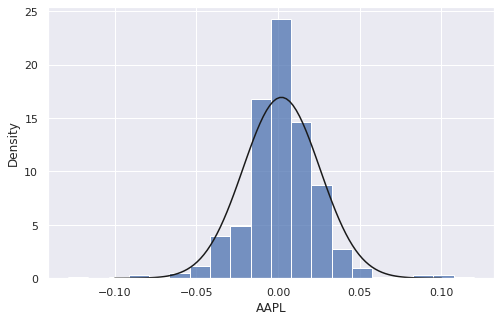

In [ ]:
# Prior distribution
plt.figure(figsize=(8,5))
muY, stdY = np.mean(returnsY), np.std(returnsY)
print('Prior Distribution: N( ' + str(round(muY,4)) + ' , ' + str(round(stdY,4)) + '^2 )')
_ = sns.histplot(returnsY, bins=20, stat='density')
x = np.linspace(-0.1, 0.1, 100)
y = norm.pdf(x, loc=muY, scale=stdY)
_ = plt.plot(x, y, 'k')

The following table shows how different stock prices individually affect the price movement in the one-day forward AAPL stock price. The probability values are close to 0.5, similar to a random walk. Maybe using the joint probability of different stock prices will provide a useful strategy

In [ ]:
N = len(returnsX)
prob = {}
for i in range(10):
    stock = equities[i]
    PX = len(returnsX.loc[returnsX[stock]>0])
    PYX1 = len(returnsX.loc[(returnsY>0) & (returnsX[stock]>0)])
    PYX2 = len(returnsX.loc[(returnsY>0) & (returnsX[stock]<0)])
    prob[stock] = [PX, PYX1, PYX2]
prob = pd.DataFrame.from_dict(prob, orient='index', columns=['P(X>0)', 'P(Y>0,X>0)', 'P(Y>0,X<0)'])
prob['P(Y>0,X>0)'] = prob['P(Y>0,X>0)'] / N
prob['P(Y>0,X<0)'] = prob['P(Y>0,X<0)'] / N
prob['P(X>0)'] = prob['P(X>0)'] / N
prob['P(Y>0|X>0)'] = prob['P(Y>0,X>0)'] / prob['P(X>0)']
prob['P(Y>0|X<0)'] = prob['P(Y>0,X<0)'] / (1 - prob['P(X>0)'])
prob.head(10)

,P(X>0),"P(Y>0,X>0)","P(Y>0,X<0)",P(Y>0|X>0),P(Y>0|X<0)
AAPL,0.534653,0.261386,0.271287,0.488889,0.582979
AMZN,0.532673,0.265347,0.269307,0.498141,0.576271
MSFT,0.544554,0.271287,0.263366,0.498182,0.578261
GOOG,0.580198,0.283168,0.251485,0.488055,0.599057
TSLA,0.556436,0.285149,0.249505,0.512456,0.562500
META,0.524752,0.273267,0.261386,0.520755,0.550000
AMD,0.504950,0.279208,0.255446,0.552941,0.516000
NVDA,0.558416,0.306931,0.225743,0.549645,0.511211
GS,0.506931,0.253465,0.281188,0.500000,0.570281
ADBE,0.560396,0.279208,0.255446,0.498233,0.581081


Let's define the likelihood function, which calculated the probability of the observed returns for reference stocks given the next day AAPL return is positive

$$ Likelihood = P(\text{X} | \text{Y>0}) = \text{Joint prob. of the returns based on historical distribution, given Y>0}$$

In [ ]:
def likelihood(returnsX, returnsY, day, window=16):
    try:
        dataY = returnsY.iloc[day-window:day]
        dataXY = returnsX.iloc[day-window:day].loc[dataY>0]
        muXY, covXY = np.mean(dataXY, axis=0), np.cov(dataXY, rowvar=False)
        PXY = multivariate_normal.pdf(returnsX.iloc[day], mean=muXY, cov=covXY)
        return PXY #*PY/PX
    except:
        return 0.5

$$ Evidence = P(\text{X}) = \text{Joint prob. of the returns based on historical distribution}$$
    
$$ Prior = P(\text{AAPL>0}) = \frac{\text{Num of instances, where AAPL return > 0}}{\text{Total num of observations}}$$

####Bayesian Trading Strategy
Everyday we estimate the probability of AAPL going up next day, given the observed returns for the ten refernce stocks. We use multivariate normal distribution to calculate the joint probabilities for the Evidence and Likelihood. The parameters for the joint distributions are calculated from a fixed number of past days (*window*). If the posterior probability is greater than *0.6*, we *BUY/LONG* AAPL stocks. If the posterior probability is less than *0.4*, we *SELL/SHORT* AAPL stocks. Otherwise, we do not trade and hold the wealth in a money-market account

In [ ]:
window = 32
threshold = 0.25

# Prior Probability
PY = np.mean(returnsY  > 0)
muX, covX = np.mean(returnsX, axis=0), np.cov(returnsX, rowvar=False)

days, p, strategy, position, stock, wealth = [window-1], [0], ['HOLD'], [0], [1], [1]
for i in range(window, len(returnsX)-1):
    # Evidence Probability
    PX = multivariate_normal.pdf(returnsX.iloc[i], mean=muX, cov=covX)
    p_bayes = likelihood(returnsX, returnsY, i, window=window)*PY/PX
    if (p_bayes < 0 or p_bayes > 1): continue
    p.append(p_bayes)
    stock.append(stock[-1]*(1 + returnsY.iloc[i]))
    days.append(i)
    if (p_bayes > 0.5 + threshold):
        if position[-1]!=1: strategy.append('BUY')
        else: strategy.append('HOLD')
        position.append(1)
        wealth.append(wealth[-1]*(1 - returnsY.iloc[i]))
    elif (p_bayes < 0.5 - threshold):
        if position[-1]!=-1: strategy.append('SELL')
        else: strategy.append('HOLD')
        position.append(-1)
        wealth.append(wealth[-1]*(1 + returnsY.iloc[i]))
    else:
        if position[-1]==1: strategy.append('SELL')
        elif position[-1]==-1: strategy.append('BUY')
        else: strategy.append('HOLD')
        position.append(0)
        wealth.append(wealth[-1])

days, p, strategy, position, stock, wealth = \
    np.array(days), np.array(p), np.array(strategy), np.array(position), np.array(stock), np.array(wealth)

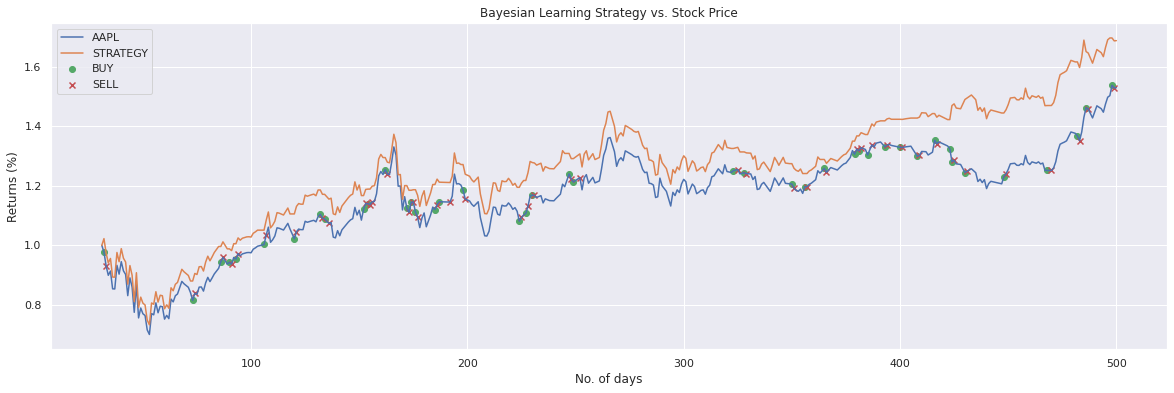

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(days, stock, label='AAPL')
plt.plot(days, wealth, label='STRATEGY')
buys = [stock[strategy=='BUY'], days[strategy=='BUY']]
sells = [stock[strategy=='SELL'], days[strategy=='SELL']]
plt.scatter(buys[1], buys[0], c='g', label='BUY')
plt.scatter(sells[1], sells[0], c='r', marker='x', label='SELL')
plt.legend()
plt.title('Bayesian Learning Strategy vs. Stock Price')
plt.xlabel('No. of days')
plt.ylabel('Returns (%)')
_ = plt.show()

In [ ]:
print("Return on AAPL stock = " + str(round(stock[-1]*100, 3)) + "%")
N = len(days)
print("Return on Bayesian Learning Trading Strategy = " + str(round(wealth[-1]*100, 3)) + "%")
print("Excess return generated by the above trading strategy = " + str(round(wealth[-1]*100 - stock[-1]*100, 3)) + "%")
print("Annualized return generated by the above strategy = " + str(round(np.power(strat_returns[-1], 252/N)*100-100, 3)) + "% p.a.")

Return on AAPL stock = 152.976%
Return on Bayesian Learning Trading Strategy = 168.818%
Excess return generated by the above trading strategy = 15.842%


In [ ]:
round(1.68818**(252/500)*100-100,3)

30.202